In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
from io import BytesIO

sns.set_theme()

De los datasets solo me quedaré con Penetración, Precio, ConsumoXCapita, GastoXCapita, Socioeconómico ConsumoXCapita, SocioEconómico Penetración


In [20]:
food_reference = pd.read_excel(r"..\datasets\spain_food_dataset\Dataset manual - Clasificacion de alimentos.xlsx")
df = pd.read_excel(r"..\datasets\spain_food_dataset\2024datosanualesdelpaneldeconsumoalimentarioenhogares.xlsx", sheet_name='SOCIOECONÓMICO PENETRACIÓN', header=2)

Solo hace falta que vaya por zips

In [39]:
def dataset_grouping_preprocessing(file_path):
    final_df_general = None
    final_df_socioeconomico = None

    excel_file = pd.ExcelFile(file_path)
    sheet_names = excel_file.sheet_names

    sheets_general = ['PENETRACIÓN', 'PRECIO', 'CONSUMOXCÁPITA', 'GASTOXCÁPITA']
    sheets_socioeconomico = ["SOCIOECONÓMICO PENETRACIÓN", "SOCIOECONÓMICO CONSUMOXCÁPITA"]
    if "SOCIOECONOMICO PENETRACION" in sheet_names and 'SOCIOECONÓMICO PENETRACIÓN' not in sheet_names:
        sheets_socioeconomico[sheets_socioeconomico.index('SOCIOECONÓMICO PENETRACIÓN')] = 'SOCIOECONOMICO PENETRACION'

    region_columns = [
        "NORESTE", "LEVANTE", "ANDALUCIA", "CENTRO-SUR",
        "CASTILLA Y LEON", "NOROESTE", "NORTE", "T.CANARIAS"
    ]
    to_exclude_cols = ["T.ESPAÑA"] + region_columns

    for sheet in sheets_general:
        df = pd.read_excel(file_path, sheet_name=sheet, header=2)
        df = df.rename(columns={'Unnamed: 0' : "Nombre original"})
        df_melted = pd.melt(df, id_vars=["Nombre original"], value_vars=df.columns[1:], var_name='CCAA', value_name=f'{sheet}').reset_index()

        if final_df_general is None:
            final_df_general = df_melted
        else:
            final_df_general = final_df_general.merge(df_melted, on=['index', 'Nombre original', 'CCAA'], how='left')

    for sheet in sheets_socioeconomico:
        df_socioeconomico = pd.read_excel(file_path, sheet_name=sheet, header=2)
        df_socioeconomico = df_socioeconomico.rename(columns={'Unnamed: 0' : "Nombre original"})
        df_socioeconomico = df_socioeconomico[[col for col in df_socioeconomico.columns if col not in to_exclude_cols]]
        df_melted_socioeconomico = pd.melt(df_socioeconomico, id_vars=['Nombre original'], value_vars=df_socioeconomico.columns[1:],
                                           var_name='var_socioeconomica',value_name=f'{sheet}').reset_index()

        if final_df_socioeconomico is None:
            final_df_socioeconomico = df_melted_socioeconomico
        else:
            final_df_socioeconomico = final_df_socioeconomico.merge(df_melted_socioeconomico, how='left', on=['index', 'Nombre original', 'var_socioeconomica'])
        
    categorias = {
    "Clase social": df_socioeconomico.columns[1:6],
    "Niños en el hogar": df_socioeconomico.columns[6:9],
    "Actividad compra": df_socioeconomico.columns[9:11],
    "Edad responsable": df_socioeconomico.columns[11:16],
    "Tamaño de hogar": df_socioeconomico.columns[16:20],
    "Tamaño de hábitat": df_socioeconomico.columns[20:25],
    "Tipo de hogar": df_socioeconomico.columns[25:34]}

    # Construir un diccionario inverso columna → grupo
    col_to_categoria = {
        col: grupo
        for grupo, cols in categorias.items()
        for col in cols
    }
    
    final_df_socioeconomico['grupo_socioeconomica'] = final_df_socioeconomico['var_socioeconomica'].map(col_to_categoria)

    return final_df_general, final_df_socioeconomico 


In [42]:
def read_and_process_zip(zip_url):

    zip_results = []
    with zipfile.ZipFile(zip_url, 'r') as zip_file:
        for file_name in zip_file.namelist():
            print(f"\nProcessing {file_name}...")
            with zip_file.open(file_name) as f:
                file_like = BytesIO(f.read())
                general_df, socioeconomico_df = dataset_grouping_preprocessing(file_like)

                #Se obtienen las primeras 4 letras (que son números), corresponden al año del dataset
                #Se creará una columna posteriormente en cada df para señalizar el año del dataset

                year = int(file_name[:4])
                
                general_df['dataset_year'] = year
                socioeconomico_df['dataset_year'] = year

                zip_results.append({
                    'general': general_df,
                    'socioeconomico': socioeconomico_df
                    })
                
    #Combino todos los dfs haciendo union en dos finales
    final_general_df = pd.concat([result['general'] for result in zip_results], ignore_index=True)
    final_socioeconomico_df = pd.concat([result['socioeconomico'] for result in zip_results], ignore_index=True)
     
    print('Reading zip files and processing all DONE')
    return final_general_df, final_socioeconomico_df

In [43]:
#Leemos los documentos guardados dentro del zip con la función read_process_zip
#Dentro de la misma función read_process_zip, se utiliza la función dataset_grouping_preprocessing para procesar las diferentes pestañas y obtener los datos de la forma deseada
#Al final, haremos union de todos los dataset obtenidos en zip_results, y obtendremos dos datasets finales. Uno de información general y otro más especefíco de datos socioeconómicos.

zip_url = '..\datasets\spain_food_dataset\dataset_anual_consumo_alimentario_España_2010a2024.zip'
final_general_df, final_socioeconomico_df = read_and_process_zip(zip_url=zip_url)



Processing 2011datosanualesdelpaneldeconsumoalimentarioenhogares.xlsx...

Processing 2012datosanualesdelpaneldeconsumoalimentarioenhogares.xlsx...

Processing 2013datosanualesdelpaneldeconsumoalimentarioenhogares.xlsx...

Processing 2014datosanualesdelpaneldeconsumoalimentarioenhogares.xlsx...

Processing 2015datosanualesdelpaneldeconsumoalimentarioenhogares.xlsx...

Processing 2016datosanualesdelpaneldeconsumoalimentarioenhogares.xlsx...

Processing 2017datosanualesdelpaneldeconsumoalimentarioenhogares.xlsx...

Processing 2018datosanualesdelpaneldeconsumoalimentarioenhogares.xlsx...

Processing 2019datosanualesdelpaneldeconsumoalimentarioenhogares.xlsx...

Processing 2020datosanualesdelpaneldeconsumoalimentarioenhogares.xlsx...

Processing 2021datosanualesdelpaneldeconsumoalimentarioenhogares.xlsx...

Processing 2022-datos-anuales-panel-consumo-hogares-base2021.xlsx...

Processing 2023-datos-anuales-panel-consumo-hogares-base2021.xlsx...

Processing 2024datosanualesdelpaneldeconsumoa

Explicar que hay en los dos dataframes que se han obtenido y por qué son diferentes

Importo un dataset manual donde se han cogido los nombres más recientes de comida en 2024, y se han creado 3 columnas:
- Categoría: Un alimento es categoría 0 cuando es demasiado genérico, es 1 cuando es representativo, es 2 cuando es demasiado específico y es 3 cuando no aporta mucho valor

PONER EJEMPLOS DE LO QUE HAY EN CADA CATEGORÍA PARA QUE SE ENTIENDA

- Nombre refinado: A los alimentos con categoría 1 (título representativo) se les asigna un nombre para mejor entendimiento. Por ejemplo T.HUEVOS KGS -> Huevos, Sardinas (cuando el dataset está haciendo referencia a conservas) -> Conservas sardina
- Categoría comida: Para poder realizar un EDA y que proporcione insights, se ha reducido la dimensionalidad de los nombres en grupos basados en la nutrición piramidal.

In [ ]:
manual_labelling_df = pd.read_excel(r'..\datasets\spain_food_dataset\Dataset manual - Clasificacion de alimentos.xlsx')

manual_labelling_df.head(10)

,Nombre original,Categoría,Nombre Refinado,Categoría comida
0,.TOTAL ALIMENTACION,0,NaN,NaN
1,T.HUEVOS KGS,0,NaN,NaN
2,T.HUEVOS UNDS.,1,Huevos,"Lácteos, Derivados y Huevos"
3,TOTAL HUEVOS GALLINA,2,NaN,NaN
4,OTRAS AVES,2,NaN,NaN
5,MIEL,1,Miel,Otros/Complementos
6,GRANEL,2,NaN,NaN
7,ENVASADA,2,NaN,NaN
8,TOTAL CARNE,0,NaN,NaN
9,CARNE CERTIFICADA,3,NaN,NaN


In [ ]:
# Uno el dataset manual_labelling_df a los dos dfs generados por las funciones de preprocesamiento, se filtrarán todos los alimentos que no hayan sido clasificados como Categoría 1 porque no nos interesan.

final_general_df = pd.merge(final_general_df, manual_labelling_df, on='Nombre original', how='left')
final_socioeconomico_df = pd.merge(final_socioeconomico_df, manual_labelling_df, on='Nombre original', how='left')

## 2. Análisis de DataFrame con datos generales

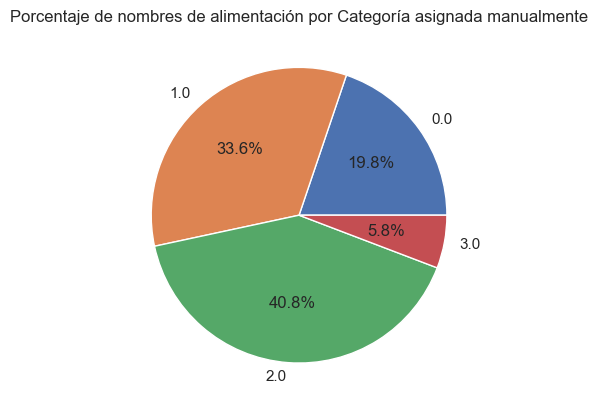

In [88]:
sizes_df = final_general_df.groupby(['dataset_year','Categoría']).size().reset_index(name='size')

fig, ax = plt.subplots()
ax.pie(sizes_df[sizes_df.dataset_year == 2024]['size'], labels=sizes_df[sizes_df.dataset_year == 2024]['Categoría'], autopct='%1.1f%%')
plt.title('Porcentaje de nombres de alimentación por Categoría asignada manualmente')
plt.show()


In [92]:
# Filtraremos todas las filas que no sean categorizados como 1 en el dataset.

filtered_general_df = final_general_df[final_general_df['Categoría'] == 1]
filtered_general_df.head()

,index,Nombre original,CCAA,PENETRACIÓN,PRECIO,CONSUMOXCÁPITA,GASTOXCÁPITA,dataset_year,Categoría,Nombre Refinado,Categoría comida
2,2,T.HUEVOS UNDS.,T.ESPAÑA,70.682500,0.123097,130.984434,16.123740,2011,1.0,Huevos,"Lácteos, Derivados y Huevos"
7,6,MIEL,T.ESPAÑA,6.459167,5.280797,0.438368,2.314934,2011,1.0,Miel,Otros/Complementos
13,12,SALCHICHAS FRESCAS,T.ESPAÑA,12.725833,6.418962,0.648186,4.160681,2011,1.0,Salchichas frescas,Carnes
14,13,CARNE VACUNO,T.ESPAÑA,52.575000,9.027366,6.577153,59.374366,2011,1.0,Carne vacuno,Carnes
18,17,CARNE POLLO,T.ESPAÑA,70.785000,4.015438,14.550497,58.426616,2011,1.0,Carne pollo,Carnes


El análisis a realizar:
- Top 5 y Bot 5 con subplots para cada variable en cada categoría comida
- Top 5 y Bot 5 en crecimiento anual (hay que calcularlo)
- Top 5 y Bot 5 de alguna forma en cada comunidad autónoma
